In [ ]:
!nvidia-smi

Wed Aug 26 13:50:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data cleaning
- Lấy data [10:05, 15:55], bỏ 10:00, 9:55 vì là dồn ứ đầu phiên, cuối phiên
- 24/12 31/12 của 2018, 2019: NULL 12 obs ==> loại ra khỏi dataset
- Lỗi dữ liệu:
'EBIAS5', 5 10 20 30
'EMA5', 5 10 20 30
'EOSCP5', 5 10 20 30
'NVI', 1:12
'PVI', 1:12

EMA, NVI, PVI: lý do: dữ liệu ngắt quãng

EBIAS5, EOSCP: ăn theo EMA

==> mỗi khi ngắt lấy giá trị có mới nhất
==> đã fix



# Setup

In [2]:
##Extension for Jupyter notebook instance of AWS
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install 
!pip install jupyter_nbextensions_configurator
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
#### toc2 extension for table of contents
!jupyter nbextension enable toc2/main

!pip install xgboost
!pip install lightgbm

     |████████████████████████████████| 20.9 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 861 kB 64.8 MB/s eta 0:00:01
     |████████████████████████████████| 479 kB 60.4 MB/s eta 0:00:01
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=ad4fbeacd2e9c2d19ec245a74394b1cc244cc7deacf192701fea7db319ef4f61
  Stored in directory: /home/ec2-user/.cache/pip/wheels/cd/51/ee/c0fe3c4463ebd357f6b135fcb58667d84079b3e0e8287ec9ea
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465825 sha256=a311d0c1fca3df75eab40cf40666228f59e0aa3c5f671e242e6bf98d19e4b0b3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ca/a9/d7/a25604ecdf245a237594b33911a4af1aff9ec3c8e517f55401
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip insta

In [3]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

bucket='test_VA'
# data_key = 'testAWS.csv'
data_key = 'testAWSfull.csv'
# data_location = 's3://{}/{}'.format(bucket, data_key)
data_location = f"s3://{bucket}/{data_key}"
import pandas as pd


print(data_location)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

### to plot bigger figure
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 15] #To change the default settings, and therefore all your plots

import warnings
warnings.filterwarnings('ignore')

import time

## This is a simple timer function that I use in most scripts. I like to know how long things take :-)
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X_train,y_train)
# timer(start_time) # timing ends here for "start_time" variable

from numpy import sort
from xgboost import XGBClassifier
import lightgbm as lgb
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# print(green_area)

s3://test_VA/testAWSfull.csv


## Function

### Data processing function

In [3]:
import math
def df_split_train_test_lastobs (df, all_features_list, test_size):
    df.sort_index(inplace=True) #sort by index for all stocks
    df = df[all_features_list + ['next_jump']]
    split_point = math.ceil(len(df)*(1-test_size))
    df_train, df_test = df.iloc[:split_point, :].copy(), df.iloc[split_point:, :].copy() # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=69)
    print(f"train - test: {len(df_train), len(df_test)}")
    return df_train, df_test

def X_y_split_train_test_lastobs (df, all_features_list, test_size):
    df.sort_index(inplace=True) #sort by index for all stocks
    y = df['next_jump']
    X = df.drop(['next_jump'], axis=1)[all_features_list]
#     test_size = 0.04
    split_point = math.ceil(len(df)*(1-test_size))
    X_train, X_test = X.iloc[:split_point, :].copy(), X.iloc[split_point:, :].copy()
    y_train, y_test = y.iloc[:split_point].copy(), y.iloc[split_point:].copy()
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=69)
#     print(f"train - test: {len(X_train), len(y_train),len(X_test), len(y_test)}")
    print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
    print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))
    return X_train, X_test, y_train, y_test


In [4]:
def extract_time_features(df):  
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df.index
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    time_features = ['month','hour','year','dayofweek']
    for time_feature in time_features:
        dummies = pd.get_dummies( df[time_feature])
        dummy_cols = pd.DataFrame(dummies).add_prefix(time_feature).columns.tolist().copy() #get col names
        dummies.columns = dummy_cols
        df = pd.concat([df, dummies], axis=1)

    df = df.drop(columns=time_features)
    df = df.drop(columns=['timestamp'])
    
    return df

def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [5]:
def statisticL(stock, K):
    stock['0'] = stock['C']
    for i in range(K):
        stock[str(i+1)] = stock['0'].shift(i+1)
    stock['sigma'] = 0
    def dflog(col1, col2):
        return np.log(col1/col2)
    for i in range(K, 1, -1):
        zero = stock[str(i-2)]
        one = stock[str(i-1)]
        two = stock[str(i)]
        stock['sigma'] += abs(dflog(zero, one)) * abs(dflog(one, two))
    stock['sigma'] /= (K-2)
    stock['L_stat'] = dflog(stock['0'], stock['1']) / stock['sigma']
    return stock

def label_jump (df, alpha = 5000):
    ##Calculate L-stat
    df = statisticL(df, 5)
    # df = df[df['sigma'].notna()] #loại 5 obs đầu trong cả bộ 35976 - 5 = 35971 obs
    df['jump'] = 'no_jump'
    df.loc[( df['sigma'] == 0 ) & ( df['0'] > df['1'] ) , 'jump'] = 'upward_jump'
    df.loc[( df['sigma'] == 0 ) & ( df['0'] < df['1'] ) , 'jump'] = 'downward_jump'

    ##Jump label
#     alpha = 5000
    df.loc[(df['L_stat'] > alpha) , 'jump'] = 'upward_jump'
    df.loc[(df['L_stat'] < -alpha) , 'jump'] = 'downward_jump'
    df['next_jump'] = df['jump'].shift(-1) #label la jump cua buoc tiep theo
    df = df[df['next_jump'].notna()] #loại obs cuối cùng không có next_jump

    drop_cols_jump = ['L_stat', '0', '1', '2', '3', '4', '5', 'sigma', 'jump']
    df = df.drop(columns=drop_cols_jump)
    
    return df

#### Technical and liquidity indicators

In [6]:
def cal_indicators_no_lags(stock):
    index = stock.index
    
    #13. Accumulation/Distribution oscillator
    stock['ADO'] = (stock['H'] - stock['O'] - stock['C'] + stock['L']) / (2 * stock['H'] - stock['L'])
    #14. True range
    stock['TR'] = pd.DataFrame({'a' : stock['H'] - stock['L'], 'b': stock['L'] - stock['C'].shift(1), 'c' : stock['H'] - stock['C'].shift(1)}).max(axis=1)
    #15. Price and volume trend
    stock['PVT'] = (stock['C'] - stock['C'].shift(1)) * stock['V'] / stock['C'].shift(1) 
    #16. On balance volume
    stock['OBV'] = np.where(stock['C'] > stock['C'].shift(1), stock['V'],
                        np.where(stock['C'] < stock['C'].shift(1), -stock['V'], 0)).cumsum() ##test OK
    
    #17. Negative volume index #18. Positive volume index
    # đã fix lỗi dữ liệu không liên tiếp: để nối tiếp bản ghi cuối cùng nếu bị trống dữ liệu
    stock.loc[index[0], 'PVI'] = 1 ## Set first row of PVI, NVI to 1 / stock.loc[index[0], 'PVI'] = stock.loc[index[0], 'C_NVI_PVI']
    stock.loc[index[0], 'NVI'] = 1
    #Tạo cột V, C ảo do V, C thật không liên tiếp
    stock['V_NVI_PVI'] = stock['V']
    stock['C_NVI_PVI'] = stock['C']
    for i in range(1, len(index)):
        # Calculate positive volume index
        if pd.isna(stock.loc[index[i], 'V_NVI_PVI']):
            stock.loc[index[i], 'PVI'] = stock.loc[index[i-1], 'PVI']
            stock.loc[index[i], 'V_NVI_PVI'] = stock.loc[index[i-1], 'V_NVI_PVI']
            stock.loc[index[i], 'C_NVI_PVI'] = stock.loc[index[i-1], 'C_NVI_PVI']
        elif stock.loc[index[i], 'V_NVI_PVI'] <= stock.loc[index[i-1], 'V_NVI_PVI']:
            stock.loc[index[i], 'PVI'] = stock.loc[index[i-1], 'PVI']
        else:
            stock.loc[index[i], 'PVI'] = stock.loc[index[i-1], 'PVI'] * stock.loc[index[i], 'C_NVI_PVI'] / stock.loc[index[i-1], 'C_NVI_PVI']

        # Calculate negative volume index
        if pd.isna(stock.loc[index[i], 'V_NVI_PVI']):
            stock.loc[index[i], 'NVI'] = stock.loc[index[i-1], 'NVI']
            stock.loc[index[i], 'V_NVI_PVI'] = stock.loc[index[i-1], 'V_NVI_PVI']
            stock.loc[index[i], 'C_NVI_PVI'] = stock.loc[index[i-1], 'C_NVI_PVI']
        elif stock.loc[index[i], 'V_NVI_PVI'] >= stock.loc[index[i-1], 'V_NVI_PVI']:
            stock.loc[index[i], 'NVI'] = stock.loc[index[i-1], 'NVI']
        else:
            stock.loc[index[i], 'NVI'] = stock.loc[index[i-1], 'NVI'] * stock.loc[index[i], 'C_NVI_PVI'] / stock.loc[index[i-1], 'C_NVI_PVI']
            
    drop_cols = ['V_NVI_PVI', 'C_NVI_PVI']
    stock = stock.drop(columns=drop_cols)
    ## End cal NVI, PVI
    
    return stock


def cal_indicators(stock, lag):
    # chưa có # 12. Commodity channel index CCI

    index = stock.index
    
    # 1.Price rate of change
    stock['PROC'+str(lag)] = (stock['C'] - stock['C'].shift(lag)) / stock['C'].shift(lag)

    # 2.Volume rate of change
    stock['VROC'+str(lag)] = (stock['V'] - stock['V'].shift(lag)) / stock['V'].shift(lag)
    
    # 3.MA
    stock['MA'+str(lag)] = stock['C'].rolling(lag).sum() / lag
   
    # 4.EMA 
    #đã fix cho dữ liệu không liên tiếp
    stock.loc[index[0], 'EMA' + str(lag)] = 0 # Set first row index of EMA equal to zero
    for i in range(1, len(index)):
        if pd.isna(stock.loc[index[i], 'V']):
            stock.loc[index[i], 'EMA'+str(lag)] = stock.loc[index[i-1], 'EMA'+str(lag)] #lấy bằng lần cuối có dữ liệu
        # Calculate exponential moving average
        else:
            stock.loc[index[i], 'EMA'+str(lag)] = 2 / (lag + 1) * stock.loc[index[i], 'C'] + (lag - 1) / (lag + 1) * stock.loc[index[i-1], 'EMA'+str(lag)]

    # 5.Bias to MA
    stock['BIAS'+str(lag)] = (stock['C'] - stock['MA'+str(lag)]) / stock['MA'+str(lag)]

    # 6.Bias to EMA
    stock['EBIAS'+str(lag)] = (stock['C'] - stock['EMA'+str(lag)]) / stock['EMA'+str(lag)]
    
    # 7.Price oscillator to MA
    stock['OSCP'+str(lag)] = (stock['MA'+str(lag)] - stock['MA'+str(lag)].shift(1)) / stock['MA'+str(lag)].shift(1)

    # 8.Price oscillator to EMA
    stock['EOSCP'+str(lag)] = (stock['EMA'+str(lag)] - stock['EMA'+str(lag)].shift(1)) / stock['EMA'+str(lag)].shift(1)
    
    # 9.Fast stochastic %K
    stock['fK'+str(lag)] = (stock['C'] - stock['L'].rolling(lag).min()) / (stock['H'].rolling(lag).max() - stock['L'].rolling(lag).min())

    # 10.Fast stochastic %D
    stock['fD'+str(lag)] = (stock['fK'+str(lag)] + stock['fK'+str(lag)].shift(1) + stock['fK'+str(lag)].shift(2)) / 3
    
    # 11.Slow stochastic %D
    stock['sD'+str(lag)] = (stock['fD'+str(lag)] + stock['fD'+str(lag)].shift(1) + stock['fD'+str(lag)].shift(2)) / 3

#     # 12. Commodity channel index CCI
#     stock['M'] = (stock['H'] + stock['C'] + stock['L']) / 3
#     stock['SM'+str(lag)] = stock['M'].rolling(lag).sum() / lag
# ###     stock['G'+str(lag)] = 0
  
    return stock



In [7]:
def cal_liquidity_measures_no_lag (stock):
    #1. Return
    stock['R'] = np.log(stock['C']) - np.log(stock['C'].shift(1))
      
    stock['rr_bidask_del'] = np.log(stock['C_bid'] + stock['C_ask']) - np.log(stock['C_bid'].shift(1) + stock['C_ask'].shift(1))
    stock['quoted_spread'] = 2 * (stock['C_ask'] - stock['C_bid']) / (stock['C_ask'] + stock['C_bid'])
    stock['effective_spread'] = abs(4*stock['C'] - 2*(stock['C_ask'] + stock['C_bid'])) / (stock['C_ask'] + stock['C_bid'])
    
    return stock

def cal_liquidity_measures (stock, lag):
    ## 7 liq measures
    #2. Cumulative return
    stock['cumR' + str(lag)] = np.log(stock['C']) - np.log(stock['C'].shift(lag))
    #3. Number of trades
    stock['no_trades' + str(lag)] = stock['no_trades'].rolling(lag).sum()
    #4.Trading volume
    stock['V' + str(lag)] = stock['V'].rolling(lag).sum()
    #5. Trading size
    stock['trade_size' + str(lag) ] = stock['V' + str(lag)] / stock['no_trades' + str(lag)]
    
    #6. Order imbalance
    #7. Depth imbalance
    
    #8. Quoted spread
    stock['quoted_spread' + str(lag)] = (stock['quoted_spread']* stock['no_trades']).rolling(lag).sum()  / stock['no_trades' + str(lag)]
    #9. Effective spread 
    stock['effective_spread' + str(lag)] = (stock['effective_spread']* stock['no_trades']).rolling(lag).sum() / stock['no_trades' + str(lag)]
    #10. Realized volatility
    stock['r_volatility' + str(lag)] = (stock['rr_bidask_del']**2).rolling(lag).sum() ##need rr_bidask_del first
    
    return stock



In [8]:
def cal_all_indicators(df):
    ### 1. Technical indicators: ##78 + 44 = 122 inds
    lag_cols_tech_inds = ['ADO', 'TR', 'PVT', 'OBV', 'NVI', 'PVI'] #5

    df = cal_indicators_no_lags(df)
    for lag_cols_tech_ind in lag_cols_tech_inds:
        for lag in list(range(1, 12+1)):
            df[lag_cols_tech_ind + str(lag)] = df[lag_cols_tech_ind].shift(lag) #12 + 1 (cả ko lag) 13*6 = 78 inds

    # tech_inds = ['PROC', 'VROC', 'MA', 'EMA', 'BIAS', 'EBIAS', 'OSCP', 'EOSCP', 'fK', 'fD', 'sD'] #11
    for lag in [5, 10, 20, 30]:
        df = cal_indicators(df, lag) # 11*4 = 44 inds


    ### 2. Liquidity indicators #13 + 84 + 7 = 104 inds
    df = cal_liquidity_measures_no_lag(df) # 
    for lag in list(range(1, 12+1)):
        df['R' + str(lag)] = df['R'].shift(lag) #12 + 1 (R ko lag)


    for lag in list(range(1, 12+1)):
        df = cal_liquidity_measures(df, lag) #12 lag * 7 + 7 avg = 91 inds

    liq_inds = ['cumR', 'no_trades', 'V', 'trade_size', 'quoted_spread', 'effective_spread', 'r_volatility'] #7 avg inds
    for liq_ind in liq_inds:
        liq_ind_cols = []
        for lag in list(range(1, 12+1)):
            liq_ind_cols.append(str(liq_ind + str(lag)))

        df['avg_' + liq_ind] = df[liq_ind_cols].mean(axis = 1)

    #drop temp col for calculation
    drop_cols_liq = ['rr_bidask_del', 'quoted_spread', 'effective_spread']  # drop sau khi tính xong
    df = df.drop(columns=drop_cols_liq)

    # df[['OSCP105', 'VROC105', 'MA105', 'sD105']][100:150]  ##sD105 nhiều null nhất
    ## sD30     2018-07-30 12:50:00  #sD30 nhiều null nhất ?_?
    
#     df = df[(df.index >='2018-07-30 12:50:00')] #Xóa Null do không có lag
    df = df[df.sD30.notna()] #sD30 lag sâu nhất
    
    ## Cũ # df[['fK1', 'fD1', 'sD1']]  #NULL do khuyết ngày 24, 27, 31/12 , 02-01 # df = df[df['sD1'].notna()] 
    
    return df

Referring to the existing studies, such as Boudtand Pertitjean (2014) and Wan et al. (2017), liquidity measures within a prior
one-hour window, i.e., 12 intervals, are adopted as candidate attributes. We
also consider the average value of each measure over the 12 intervals as a new
attribute. Thus, we construct 130 candidate attributes from the 10 liquidity
measures.

No gold standard exists to choose the time lag for intraday technical
indicators. To reflect the market change within a moderately longer period,
lags of q = 5; 10; 20; 30 are used to define our intraday technical indicators,
which provides 54 candidate attributes. Thus, the total number of candidate
attributes is 184.

#### Reduce memory usage

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Full data flow

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def full_data_prep(x1):
    # bỏ tạm time features đi để cùng chiều giữa các stock

    ## Technical and liquidity indicators calculation
    before_adding_tech_inds = list(x1).copy()
    x1 = cal_all_indicators(x1) # 226 tech inds
    after_adding_tech_inds = list(x1).copy()

    all_inds_list = list(set(after_adding_tech_inds) - set(before_adding_tech_inds))
    all_inds_list.sort()
    print(f"total technical and liquidity features: {len(list(all_inds_list))}")


    ## Jump label
    x1 = label_jump(x1, alpha = 5000)
    print(x1['next_jump'].value_counts())

#     ## Time Features
#     print(f"len x1:{len(list(x1))}")
#     before_adding_timefeatures = list(x1).copy()
#     x1 = extract_time_features(x1)
#     after_adding_timefeatures = list(x1).copy()
#     dummy_time_features = list(set(after_adding_timefeatures) - set(before_adding_timefeatures))
#     dummy_time_features.sort()
#     # dummy_time_features
#     print(f"len x1:{len(list(x1))}, len dummy_time_features:{len(list(dummy_time_features))}")
    dummy_time_features = []


    ## Combine all features to all_features_list
    # dummy_time_features = []
    all_features_list = all_inds_list + dummy_time_features

    print(len(all_inds_list), len(dummy_time_features), len(all_features_list))

    #drop all cols that are not features or target col
    drop_cols = list(set(list(x1)) - set(all_features_list) - set(['next_jump']))
    x1 = x1.drop(columns=drop_cols)

    ## Push the label (next_jump) column to the end of the dataframe
    cols = list(x1)
    cols.append(cols.pop(cols.index('next_jump')))
    x1 = x1.loc[:, cols].copy()
    
    return x1


# def apply_scaler(x1):
#     ##Apply Scaler
#     # MinMaxScaler
#     scaler=MinMaxScaler()
#     df_MinMaxScaler = x1.copy()
#     df_MinMaxScaler.iloc[:, 0:-1] = scaler.fit_transform(df_MinMaxScaler.iloc[:, 0:-1]) #MinMaxScaler return a numpy array
#     df_MinMaxScaler.iloc[:, 0:-1] = pd.DataFrame(df_MinMaxScaler.iloc[:, 0:-1], index=df_MinMaxScaler.index, columns=df_MinMaxScaler.columns) #transform it back to dataframe

#     # StandardScaler
#     scaler=StandardScaler()
#     df_StandardScaler = x1.copy()
#     df_StandardScaler.iloc[:, 0:-1] = scaler.fit_transform(df_StandardScaler.iloc[:, 0:-1]) #StandardScaler return a numpy array
#     df_StandardScaler.iloc[:, 0:-1] = pd.DataFrame(df_StandardScaler.iloc[:, 0:-1], index=df_StandardScaler.index, columns=df_StandardScaler.columns) #transform it back to dataframe

# #     list_dfs = [x1, df_MinMaxScaler, df_StandardScaler]

#     #Reduce mem usage
#     x1.iloc[:, 0:-1] = reduce_mem_usage(x1.iloc[:, 0:-1])
#     df_MinMaxScaler.iloc[:, 0:-1] = reduce_mem_usage(df_MinMaxScaler.iloc[:, 0:-1])
#     df_StandardScaler.iloc[:, 0:-1] = reduce_mem_usage(df_StandardScaler.iloc[:, 0:-1])
# #     x1 = x1.copy()
# #     df_MinMaxScaler = df_MinMaxScaler.copy()
# #     df_StandardScaler = df_StandardScaler.copy()
# #     all_features_list = all_features_list.copy()

#     return x1, df_MinMaxScaler, df_StandardScaler
# #     return df_MinMaxScaler, df_StandardScaler, all_features_list


In [11]:
def apply_scaler(df):
    # Phải đầy next_jump về cuối
    ##Apply Scaler
    # MinMaxScaler
    all_features_list = list(df.drop(columns=['code', 'next_jump']))
    all_features_list.sort()
    df = df[all_features_list + ['next_jump']]
    scaler=MinMaxScaler()
    df_MinMaxScaler = df.copy()
    df_MinMaxScaler.iloc[:, 0:-1] = scaler.fit_transform(df_MinMaxScaler.iloc[:, 0:-1]) #MinMaxScaler return a numpy array
    df_MinMaxScaler.iloc[:, 0:-1] = pd.DataFrame(df_MinMaxScaler.iloc[:, 0:-1], index=df_MinMaxScaler.index, columns=df_MinMaxScaler.columns) #transform it back to dataframe

    # StandardScaler
    scaler=StandardScaler()
    df_StandardScaler = df.copy()
    df_StandardScaler.iloc[:, 0:-1] = scaler.fit_transform(df_StandardScaler.iloc[:, 0:-1]) #StandardScaler return a numpy array
    df_StandardScaler.iloc[:, 0:-1] = pd.DataFrame(df_StandardScaler.iloc[:, 0:-1], index=df_StandardScaler.index, columns=df_StandardScaler.columns) #transform it back to dataframe

#     list_dfs = [df, df_MinMaxScaler, df_StandardScaler]

    #Reduce mem usage
    df.iloc[:, 0:-1] = reduce_mem_usage(df.iloc[:, 0:-1])
    df_MinMaxScaler.iloc[:, 0:-1] = reduce_mem_usage(df_MinMaxScaler.iloc[:, 0:-1])
    df_StandardScaler.iloc[:, 0:-1] = reduce_mem_usage(df_StandardScaler.iloc[:, 0:-1])
#     df = df.copy()
#     df_MinMaxScaler = df_MinMaxScaler.copy()
#     df_StandardScaler = df_StandardScaler.copy()
#     all_features_list = all_features_list.copy()

    return df, df_MinMaxScaler, df_StandardScaler

### Get results

In [195]:
def get_results(y_test, y_pred):
#     import time

    df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    df_confusion['recall'] = 'OK'

    n_true_downward_jump = df_confusion['downward_jump'][0]
    n_true_no_jump = df_confusion['no_jump'][1]
    n_true_upward_jump = df_confusion['upward_jump'][2]

    n_actual_downward_jump = df_confusion['All'][0]
    n_actual_no_jump = df_confusion['All'][1]
    n_actual_upward_jump = df_confusion['All'][2]
    n_actual_all = df_confusion['All'][3]

    n_predicted_downward_jump = df_confusion['downward_jump'][3]
    n_predicted_no_jump = df_confusion['no_jump'][3]
    n_predicted_upward_jump = df_confusion['upward_jump'][3]

    recall_downward_jump = n_true_downward_jump/ n_actual_downward_jump
    recall_no_jump = n_true_no_jump/ n_actual_no_jump
    recall_upward_jump = n_true_upward_jump/ n_actual_upward_jump

    acc = (n_true_downward_jump + n_true_no_jump + n_true_upward_jump) / n_actual_all

    df_confusion['recall'][0] = f"{round(recall_downward_jump * 100, 2)}%"
    df_confusion['recall'][1] = f"{round(recall_no_jump * 100, 2)}%"
    df_confusion['recall'][2] = f"{round(recall_upward_jump * 100, 2)}%"
    df_confusion['recall'][3] = f"{round(acc * 100, 2)}%"

    # print(confusion_matrix(y_test, predictions))
#     print (f"result at {time.time()})
#     print(classification_report(y_test, y_pred))
    print(df_confusion)
#     return df_confusion

In [196]:
get_results(y_test, y_pred)

Predicted      downward_jump  no_jump  upward_jump   All  recall
Actual                                                          
downward_jump            511      108          427  1046  48.85%
no_jump                   37      970           39  1046  92.73%
upward_jump              354       82          531   967  54.91%
All                      902     1160          997  3059  65.77%


# Feature engineering

## Technical and liquidity indicators calculation

In [100]:
before_adding_tech_inds = list(x1).copy()
x1 = cal_all_indicators(x1) # 226 tech inds
after_adding_tech_inds = list(x1).copy()

all_inds_list = list(set(after_adding_tech_inds) - set(before_adding_tech_inds))
all_inds_list.sort()
print(f"total technical and liquidity features: {len(list(all_inds_list))}")

total technical and liquidity features: 226


## Jump label

In [101]:
%%time
x1 = label_jump(x1, alpha = 5000)
print(x1['next_jump'].value_counts())

# target_encode_df = pd.DataFrame(
# [
#     ['no_jump', 0],
#     ['upward_jump', 1],
#     ['downward_jump', 2]  
# ]
#     , columns=['label', 'encoded_label']
# )
# target_encode_df

# # Encoding column 'state',
# # failed = 0, successful = 1

# df['state'] = df['state'].map({
#         'failed': 0,
#         'successful': 1         
# })

no_jump          152
upward_jump        8
downward_jump      6
Name: next_jump, dtype: int64
CPU times: user 33.6 ms, sys: 4.29 ms, total: 37.9 ms
Wall time: 35.1 ms


## Time features

In [102]:
%%time
print(f"len x1:{len(list(x1))}")
before_adding_timefeatures = list(x1).copy()
x1 = extract_time_features(x1)
after_adding_timefeatures = list(x1).copy()
dummy_time_features = list(set(after_adding_timefeatures) - set(before_adding_timefeatures))
dummy_time_features.sort()
# dummy_time_features
print(f"len x1:{len(list(x1))}, len dummy_time_features:{len(list(dummy_time_features))}")


len x1:243
len x1:255, len dummy_time_features:12
CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 20.5 ms


## Combine all features to all_features_list

In [103]:
# dummy_time_features = []
all_features_list = all_inds_list + dummy_time_features

print(len(all_inds_list), len(dummy_time_features), len(all_features_list))

#drop all cols that are not features or target col
drop_cols = list(set(list(x1)) - set(all_features_list) - set(['next_jump']))
x1 = x1.drop(columns=drop_cols)

# Push the label (next_jump) column to the end of the dataframe
cols = list(x1)
cols.append(cols.pop(cols.index('next_jump')))
x1 = x1.loc[:, cols]

226 12 238


## Scaling X using MinMaxScaler and StandardScaler

In [107]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_MinMaxScaler = x1.copy()
df_MinMaxScaler.iloc[:, 0:-1] = scaler.fit_transform(df_MinMaxScaler.iloc[:, 0:-1]) #MinMaxScaler return a numpy array
df_MinMaxScaler.iloc[:, 0:-1] = pd.DataFrame(df_MinMaxScaler.iloc[:, 0:-1], index=df_MinMaxScaler.index, columns=df_MinMaxScaler.columns) #transform it back to dataframe

# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_StandardScaler = x1.copy()
df_StandardScaler.iloc[:, 0:-1] = scaler.fit_transform(df_StandardScaler.iloc[:, 0:-1]) #StandardScaler return a numpy array
df_StandardScaler.iloc[:, 0:-1] = pd.DataFrame(df_StandardScaler.iloc[:, 0:-1], index=df_StandardScaler.index, columns=df_StandardScaler.columns) #transform it back to dataframe

list_dfs = [x1, df_MinMaxScaler, df_StandardScaler]

In [90]:
%%time
#Reduce mem usage
x1.iloc[:, 0:-1] = reduce_mem_usage(x1.iloc[:, 0:-1])
df_MinMaxScaler.iloc[:, 0:-1] = reduce_mem_usage(df_MinMaxScaler.iloc[:, 0:-1])
df_StandardScaler.iloc[:, 0:-1] = reduce_mem_usage(df_StandardScaler.iloc[:, 0:-1])

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.09 MB
Decreased by 70.9%
Memory usage of dataframe is 0.32 MB
Memory usage after optimization is: 0.08 MB
Decreased by 74.7%
Memory usage of dataframe is 0.32 MB
Memory usage after optimization is: 0.08 MB
Decreased by 74.7%
CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.07 s


## Visualize the imbalanced dataset

Text(0.5, 1.0, 'Jump label Distributions \n (no_jump || downward_jump || upward_jump)')

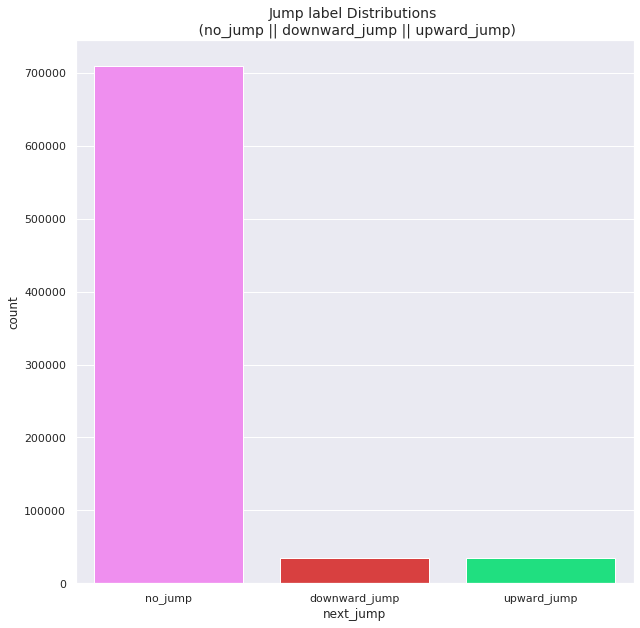

In [101]:
plt.rcParams['figure.figsize'] = [10, 10] #To change the default settings, and therefore all your plots

colors = ["#FF7FFF", "#F22626", "#00FF80"]


sns.countplot('next_jump', data=x1_full, palette=colors)
plt.title('Jump label Distributions \n (no_jump || downward_jump || upward_jump)', fontsize=14)

------------df after undersampling------------
no_jump          709587
upward_jump       35325
downward_jump     35308
Name: next_jump, dtype: int64
no_jump          35325
upward_jump      35325
downward_jump    35308
Name: next_jump, dtype: int64
X Training Observations: 105958
y Training Observations: 105958


Text(0.5, 1.0, 'Jump label Distributions \n (no_jump || downward_jump || upward_jump)')

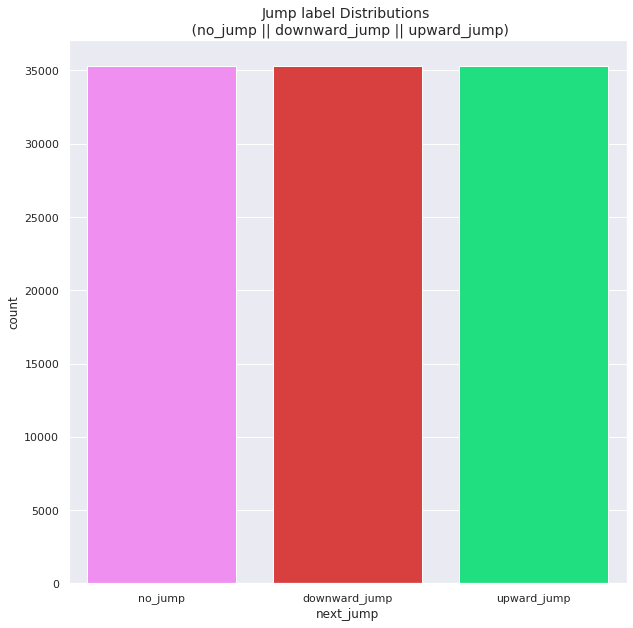

In [112]:
##After undersampling
all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
# df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler_full, all_features_list, test_size = 0.0001)
# X, y, X_test, y_test = undersampling_df_train_test(df_train, df_test)
X, y = undersampling_df(x1_full)
df = pd.concat([X, y], axis=1)
plt.rcParams['figure.figsize'] = [10, 10] #To change the default settings, and therefore all your plots

colors = ["#FF7FFF", "#F22626", "#00FF80"]


sns.countplot('next_jump', data=df, palette=colors)
plt.title('Jump label Distributions \n (no_jump || downward_jump || upward_jump)', fontsize=14)

## Dimensionality Reduction and Clustering:

### PCA

In [60]:
# New_df is from the random undersample data (fewer instances)
# X = df_MinMaxScaler.drop('next_jump', axis=1)
# y = df_MinMaxScaler['next_jump']
# X = df_StandardScaler.drop('next_jump', axis=1)
# y = df_StandardScaler['next_jump']

X, y = undersampling_df(df_StandardScaler )
# X, y = undersampling_df(df_MinMaxScaler )
# X, y = undersampling_df(x1)

------------df after undersampling------------
no_jump          32391
upward_jump       1798
downward_jump     1753
Name: next_jump, dtype: int64
no_jump          1798
upward_jump      1798
downward_jump    1753
Name: next_jump, dtype: int64
X Training Observations: 5349
y Training Observations: 5349


Explained Variance ratio by Principal Component  1  :  0.2157584274473021
Explained Variance ratio by Principal Component  2  :  0.10841605238126034
Explained Variance ratio by Principal Component  3  :  0.09001734178944219
Explained Variance ratio by Principal Component  4  :  0.07980335320635645
Explained Variance ratio by Principal Component  5  :  0.050881630073738984
Explained Variance ratio by Principal Component  6  :  0.032566221529994305
Explained Variance ratio by Principal Component  7  :  0.024496059326714392
Explained Variance ratio by Principal Component  8  :  0.01952277874790226
Explained Variance ratio by Principal Component  9  :  0.017256866538618718
Explained Variance ratio by Principal Component  10  :  0.016543014797175216
Explained Variance ratio by Principal Component  11  :  0.014722595792092463
Explained Variance ratio by Principal Component  12  :  0.012324092683600994
Explained Variance ratio by Principal Component  13  :  0.01026346014963204
Explained Varia

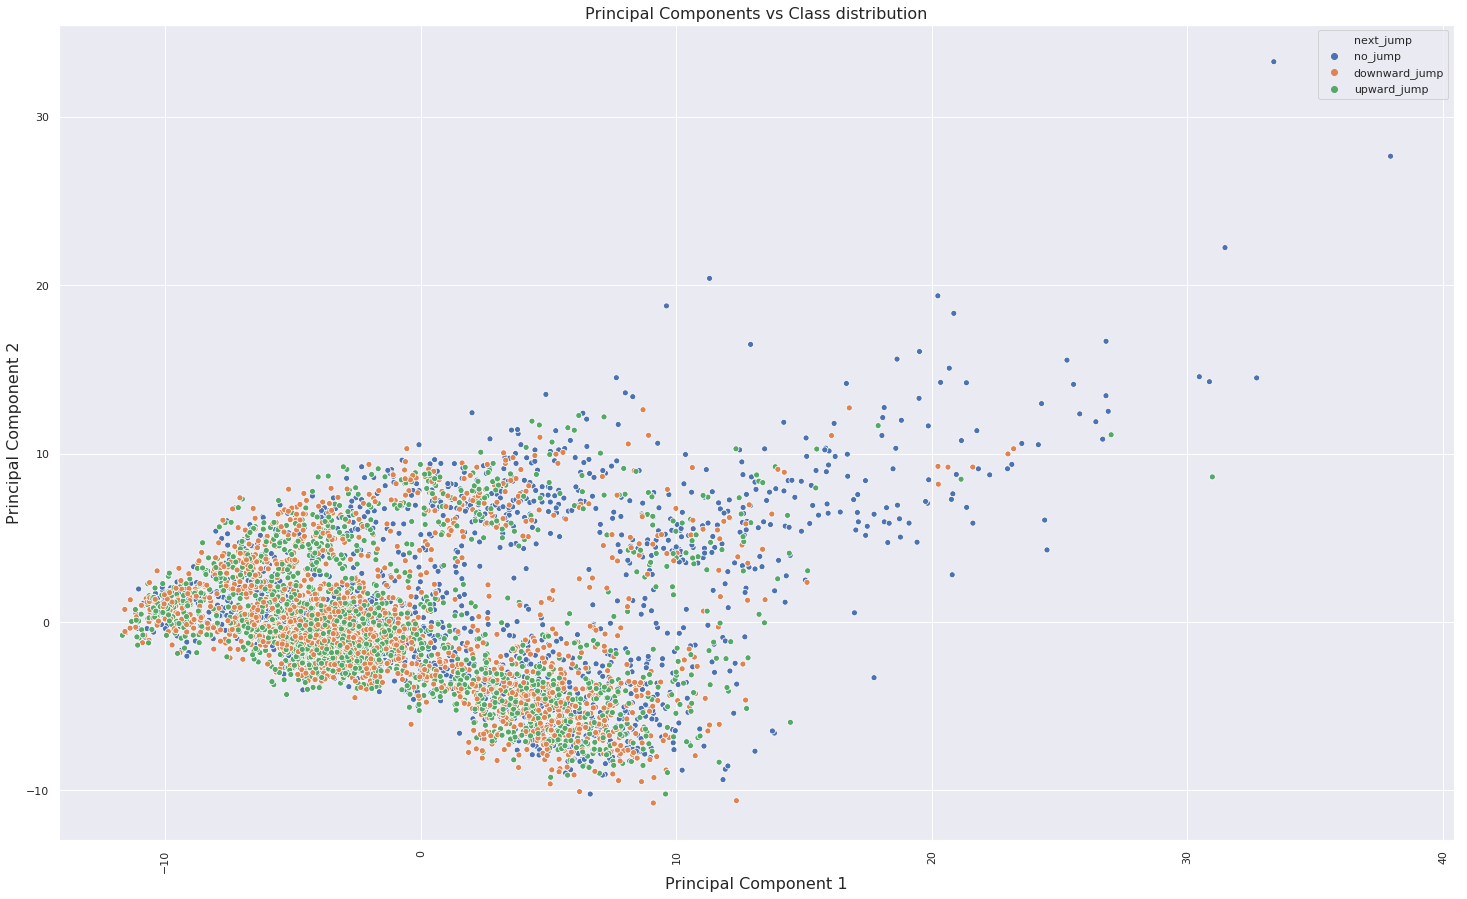

In [61]:
from sklearn.decomposition import PCA

# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(brainwave_df)
pca = PCA(n_components = 20)
pca_vectors = pca.fit_transform(X)
for index, var in enumerate(pca.explained_variance_ratio_):
    print("Explained Variance ratio by Principal Component ", (index+1), " : ", var)
    
# # !pip install seaborn
# !pip3 install seaborn==0.10.1
plt.figure(figsize=(25,15))
sns.scatterplot(x=pca_vectors[:, 0], y=pca_vectors[:, 1], hue=y)
# sns.regplot(x=pca_vectors[:, 0], y=pca_vectors[:, 1]
# #             , hue =y
#             , fit_reg=False);

plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

### TruncatedSVD


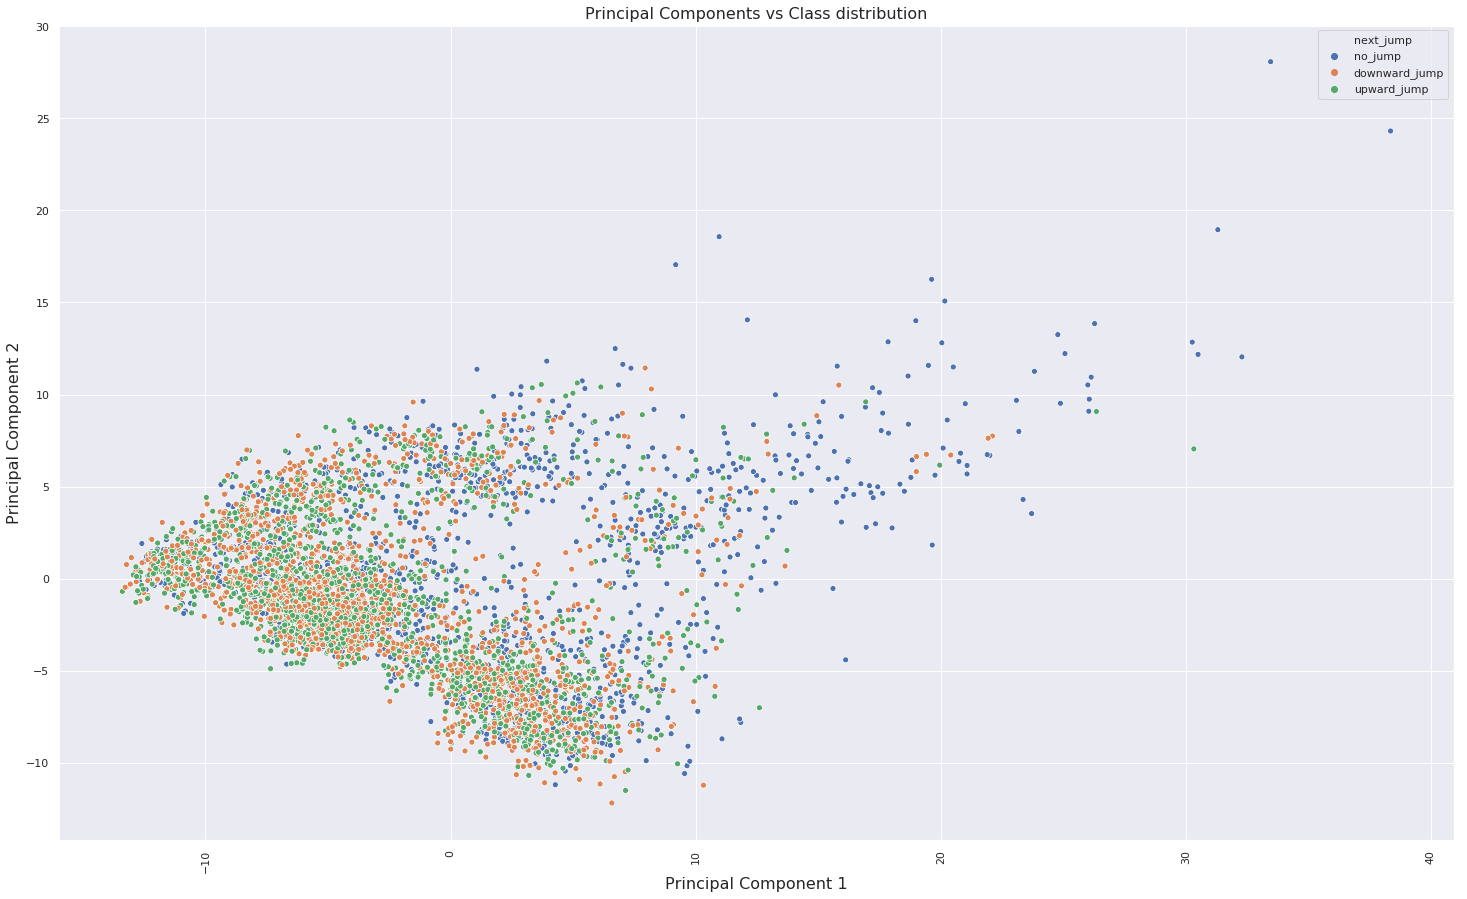

In [62]:
from sklearn.decomposition import TruncatedSVD


t_svd = TruncatedSVD(n_components=20, algorithm='randomized', random_state=42)
t_svd_vectors = t_svd.fit_transform(X)

plt.figure(figsize=(25,15))
sns.scatterplot(x=t_svd_vectors[:, 0], y=t_svd_vectors[:, 1], hue=y)
# sns.regplot(x=t_svd_vectors[:, 0], y=t_svd_vectors[:, 1]
# #             , hue =y
#             , fit_reg=False);

plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

### T-SNE

In [63]:
from sklearn.manifold import TSNE
import time

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))
# X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

T-SNE took 4.2e+01 s


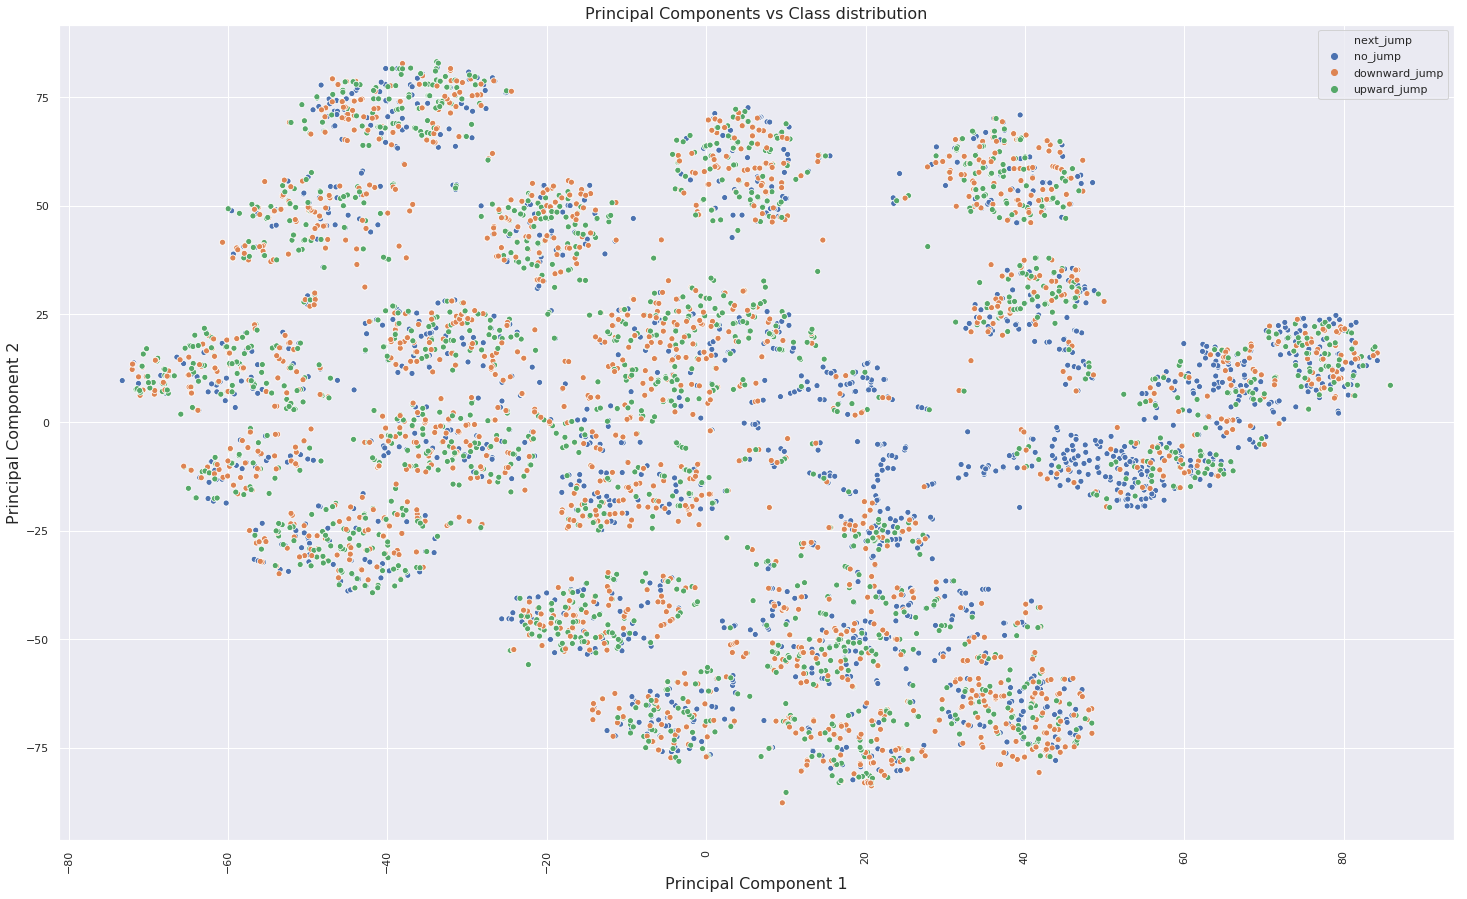

In [64]:
plt.figure(figsize=(25,15))
sns.scatterplot(x=X_reduced_tsne[:, 0], y=X_reduced_tsne[:, 1], hue=y)

plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

## Boruta feature selection

In [205]:
!pip install boruta
# !pip install sklearn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [147]:
green_areas = []
blue_areas = []

In [2]:
# all_features_list = list(x1_full_tam_thoi.drop(columns=['code', 'next_jump']))
# df_train, df_test = df_split_train_test_lastobs(x1_full_tam_thoi, all_features_list, test_size = 0.01)
# X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)


In [5]:
%%time
## !pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

###initialize Boruta
# regressor = RandomForestRegressor(
#    n_jobs = -1, 
#    max_depth = 5
# )
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

boruta = BorutaPy(
   estimator = rf, 
   n_estimators = 'auto',
   max_iter = 1 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)

# X_boruta = np.array(X_train)
# y_boruta = np.array(y_train)

X_boruta = X_train.values
# y_boruta = y_train.values.ravel()
y_boruta = y_train.values.reshape(-1, 1)

boruta.fit(X_boruta, y_boruta)

# boruta.fit(np.array(X_train), np.array(y_train))
# boruta.fit(np.array(X_train), np.array(y_train).reshape(len(np.array(y_train)), 1))


# boruta.fit(X_train.values, y_train.values.ravel())
# boruta.fit(X_train.values, np.array(y_train).reshape(len(np.array(y_train)), 1))

# y_train2 = np.ones(y_train.shape[0]).ravel()


# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=4242, max_iter = 50, perc = 90)
# boruta_feature_selector.fit(X_train.values, y_train.values.ravel())

# ## print results
# # green_area = X_train.columns[boruta.support_].to_list()
# # blue_area = X_train.columns[boruta.support_weak_].to_list()

# green_area = list(X_train.columns[boruta.support_])
# blue_area = list(X_train.columns[boruta.support_weak_])


# print(len(green_area), 'features in the green area:', green_area)
# print(len(green_area), 'features in the blue area:', blue_area)
# green_areas.append(green_area)
# blue_areas.append(blue_area)

In [204]:
boruta = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
X_boruta = X_train.values
# y_boruta = y_train.values.ravel()
y_boruta = y_train.values.reshape(-1, 1)

boruta.fit(X_boruta, y_boruta)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [202]:
X_boruta = X_train.values
# y_boruta = y_train.values.ravel()
y_boruta = y_train.values.reshape(-1, 1)
X_boruta.shape, y_boruta.shape

((105971, 188), (105971, 1))

In [162]:
X_train.values.shape, y_train.values.ravel().shape

((105971, 188), (105971,))

In [492]:
print(len(green_area), 'features in the green area:', green_area)
print(len(green_area), 'features in the blue area:', blue_area)
green_areas.append(green_area)
blue_areas.append(blue_area)

52 features in the green area: ['no_trades', 'ADO', 'TR', 'PVT', 'TR1', 'TR2', 'TR3', 'TR4', 'PVT1', 'PVT2', 'PROC5', 'BIAS5', 'EBIAS5', 'OSCP5', 'EOSCP5', 'fK5', 'sD5', 'BIAS10', 'EBIAS10', 'EOSCP10', 'fK10', 'EBIAS20', 'EOSCP20', 'R', 'R1', 'R2', 'R3', 'cumR1', 'no_trades1', 'r_volatility1', 'cumR2', 'r_volatility2', 'cumR3', 'r_volatility3', 'cumR4', 'effective_spread4', 'r_volatility4', 'cumR5', 'r_volatility5', 'cumR6', 'r_volatility6', 'cumR7', 'r_volatility7', 'cumR8', 'r_volatility8', 'cumR9', 'r_volatility9', 'r_volatility10', 'r_volatility11', 'r_volatility12', 'avg_cumR', 'avg_r_volatility']
52 features in the blue area: ['fD5', 'sD10', 'V4', 'V7']


In [259]:
## !pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

###initialize Boruta
# regressor = RandomForestRegressor(
#    n_jobs = -1, 
#    max_depth = 5
# )
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)


boruta = BorutaPy(
   estimator = rf, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
# boruta.fit(np.array(X_train), np.array(y_train))
# boruta.fit(X_train.values, y_train.values.ravel())
boruta.fit(X_train.values, y_train.values.ravel())


# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=4242, max_iter = 50, perc = 90)
# boruta_feature_selector.fit(X_train.values, y_train.values.ravel())

## print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print(len(green_area), 'features in the green area:', green_area)
print(len(green_area), 'features in the blue area:', blue_area)
green_areas.append(green_area)
blue_areas.append(blue_area)

51 features in the green area: ['ADO', 'TR', 'PVT', 'TR1', 'TR2', 'TR3', 'PVT1', 'PVT2', 'PVT3', 'PVI11', 'PROC5', 'BIAS5', 'EBIAS5', 'OSCP5', 'EOSCP5', 'fK5', 'BIAS10', 'EBIAS10', 'EOSCP10', 'fK10', 'R', 'R1', 'R2', 'R3', 'cumR1', 'no_trades1', 'V1', 'r_volatility1', 'cumR2', 'no_trades2', 'r_volatility2', 'cumR3', 'no_trades3', 'r_volatility3', 'cumR4', 'r_volatility4', 'cumR5', 'r_volatility5', 'cumR6', 'r_volatility6', 'cumR7', 'r_volatility7', 'cumR8', 'r_volatility8', 'cumR9', 'r_volatility9', 'r_volatility10', 'r_volatility11', 'r_volatility12', 'avg_cumR', 'avg_r_volatility']
51 features in the blue area: ['V2']


In [505]:
green_area.sort()
len(green_area)
print(green_area)

['ADO', 'BIAS10', 'BIAS5', 'EBIAS10', 'EBIAS20', 'EBIAS5', 'EMA30', 'EOSCP10', 'EOSCP20', 'EOSCP5', 'OSCP5', 'PROC5', 'PVI10', 'PVT', 'PVT1', 'PVT2', 'R', 'R1', 'R2', 'R3', 'TR', 'TR1', 'TR2', 'TR3', 'TR4', 'V1', 'avg_cumR', 'avg_r_volatility', 'cumR1', 'cumR2', 'cumR3', 'cumR4', 'cumR5', 'cumR6', 'cumR7', 'cumR8', 'cumR9', 'effective_spread4', 'fD5', 'fK10', 'fK20', 'fK5', 'no_trades', 'no_trades1', 'quoted_spread9', 'r_volatility1', 'r_volatility10', 'r_volatility11', 'r_volatility12', 'r_volatility2', 'r_volatility3', 'r_volatility4', 'r_volatility5', 'r_volatility6', 'r_volatility7', 'r_volatility8', 'r_volatility9', 'sD5']


In [502]:
in2_but_not_in1 = list(set(green_area2) - set(green_area1))
green_area = green_area1 + in2_but_not_in1

## BorutaShap

In [294]:
# !pip install BorutaShap
from BorutaShap import BorutaShap, load_data
from xgboost import XGBClassifier
# X, y = load_data(data_type='classification')
# X

label_encoded_yfrom sklearn.preprocessing import LabelEncoder
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
label_encoded_y = label_encoder.transform(y_train)

model = XGBClassifier()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

# Feature_Selector.fit(X=X, y=y, n_trials=10, random_state=0)
# Feature_Selector.fit(X = X_train.values,y =  y_train.values.ravel(),  n_trials=10
# #                      , random_state=0
#                     )


Feature_Selector.fit(X = X_train,y = label_encoded_y,  n_trials=1
                     , random_state=0
                    )

# Full data flow

## Load everything to a df

In [31]:
bucket='test_VA'
data_key = 'testAWSfull.csv'
# data_key = 'testAWS.csv'
# data_location = 's3://{}/{}'.format(bucket, data_key)
data_location = f"s3://{bucket}/{data_key}"

In [39]:

data = pd.read_csv(data_location)
data.time = pd.to_datetime(data.time.str[:29])
data.set_index("time", inplace=True)

all_codes = ['ALL.AX', 'AMC.AX', 'ANZ.AX', 'BHP.AX', 'BXB.AX', 'CBA.AX',
       'CSL.AX', 'GMG.AX', 'IAG.AX', 'MQG.AX', 'NAB.AX', 'NCM.AX',
       'RIO.AX', 'S32.AX', 'SCG.AX', 'SUN.AX', 'TCL.AX', 'TLS.AX',
       'WBC.AX', 'WES.AX', 'WOW.AX', 'WPL.AX']

In [40]:
%%time
x1_full = pd.DataFrame()
# df_MinMaxScaler_full = pd.DataFrame()
# df_StandardScaler_full = pd.DataFrame()

# --2min 40s for 2 codes vs 5min 1s for 2 codes, 23min 1s for 22 stocks, 25min 55s 2nd time
for i in list(range(len(all_codes))):
# for i in list(range(2)):    
    code = all_codes[i]
    print(f"---------------Started processing code {i}. {code}---------------")
    x1 = data[(data.code == code )]
    x1 = x1.drop(columns=['code']).copy()
#     x1 = x1[:100]
    # all_features_list = []
    x1= full_data_prep(x1)
    x1['code'] = code
    x1_full = pd.concat([x1_full, x1])

---------------Started processing code 0. ALL.AX---------------
total technical and liquidity features: 226
no_jump          33471
downward_jump     1154
upward_jump       1147
Name: next_jump, dtype: int64
226 0 226
---------------Started processing code 1. AMC.AX---------------
total technical and liquidity features: 226
no_jump          31488
downward_jump     1905
upward_jump       1855
Name: next_jump, dtype: int64
226 0 226
---------------Started processing code 2. ANZ.AX---------------
total technical and liquidity features: 226
no_jump          32445
downward_jump     1639
upward_jump       1565
Name: next_jump, dtype: int64
226 0 226
---------------Started processing code 3. BHP.AX---------------
total technical and liquidity features: 226
no_jump          32271
upward_jump       1790
downward_jump     1745
Name: next_jump, dtype: int64
226 0 226
---------------Started processing code 4. BXB.AX---------------
total technical and liquidity features: 226
no_jump          32634
d

In [43]:
# x1_full.to_csv('x1_full.csv', index=True)

## Check if any NULL

In [44]:
print(x1_full.code.value_counts())
# find NULL
df = x1_full
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
print("Return NULL rows and cols (if any)")
df.loc[row_mask,col_mask]


CSL.AX    35806
BHP.AX    35806
RIO.AX    35800
ALL.AX    35772
GMG.AX    35772
BXB.AX    35738
CBA.AX    35703
MQG.AX    35668
ANZ.AX    35649
TLS.AX    35624
WOW.AX    35588
WPL.AX    35489
NAB.AX    35452
WBC.AX    35452
NCM.AX    35421
WES.AX    35347
S32.AX    35281
AMC.AX    35248
TCL.AX    35204
SUN.AX    34921
IAG.AX    34858
SCG.AX    34621
Name: code, dtype: int64
Return NULL rows and cols (if any)


""
time


In [45]:
all_features_list = list(x1_full.drop(columns=['code', 'next_jump']))
all_features_list.sort()
len(x1_full), len(x1_full[x1_full.PVI.isna()]),  len(x1_full[x1_full.EMA10.isna()])

(780220, 0, 0)

## Apply MinMaxScaler, StandardScaler

In [46]:
x1_full_x, df_MinMaxScaler_full, df_StandardScaler_full = apply_scaler(x1_full)
len(all_features_list), len(list(x1_full_x)), len(list(df_MinMaxScaler_full)), len(list(df_StandardScaler_full))
# x1_full_x.to_csv('x1_full_x.csv', index=True)
df_MinMaxScaler_full.to_csv('df_MinMaxScaler_full_x.csv', index=True)
df_StandardScaler_full.to_csv('df_StandardScaler_full_x.csv', index=True)
print("Done exporting to csv")

Memory usage of dataframe is 1351.24 MB
Memory usage after optimization is: 409.24 MB
Decreased by 69.7%
Memory usage of dataframe is 1351.24 MB
Memory usage after optimization is: 342.27 MB
Decreased by 74.7%
Memory usage of dataframe is 1351.24 MB
Memory usage after optimization is: 342.27 MB
Decreased by 74.7%
Done exporting to csv


## Handling imbalaced dataset

In [ ]:
def undersampling_df_train(df_train, df_test):
    # Class count
    count_no_jump, count_upward_jump, count_downward_jump = df_train['next_jump'].value_counts()
    # Divide by class
    df_no_jump = df_train[df_train['next_jump'] == 'no_jump']
    df_have_jump = df_train[df_train['next_jump'] != 'no_jump']
    # Undersampling no_jump class
    df_no_jump_under = df_no_jump.sample(max(count_upward_jump, count_downward_jump))
    # Concat with the df_have_jump
    df_train_resampled = pd.concat([df_no_jump_under, df_have_jump], axis=0)
    print("------------df_train after undersampling------------")
    print(df_train['next_jump'].value_counts())
    print(df_train_resampled['next_jump'].value_counts())

    y_train = df_train_resampled['next_jump']
    X_train = df_train_resampled.drop(['next_jump'], axis=1)
    
    
    y_test = df_test['next_jump']
    X_test = df_test.drop(['next_jump'], axis=1)
    
    print('X Training Observations: %d' % (len(X_train.index)))
    print('X Testing Observations: %d' % (len(X_test.index)))
    print('y Training Observations: %d' % (len(y_train)))
    print('y Testing Observations: %d' % (len(y_test)))
    
    return X_train, y_train, X_test, y_test

In [ ]:
def undersampling_df_train_test(df_train, df_test):
    # Class count
    count_no_jump, count_upward_jump, count_downward_jump = df_train['next_jump'].value_counts()
    # Divide by class
    df_no_jump = df_train[df_train['next_jump'] == 'no_jump']
    df_have_jump = df_train[df_train['next_jump'] != 'no_jump']
    # Undersampling no_jump class
    df_no_jump_under = df_no_jump.sample(max(count_upward_jump, count_downward_jump))
    # Concat with the df_have_jump
    df_train_resampled = pd.concat([df_no_jump_under, df_have_jump], axis=0)
    print("------------df_train after undersampling------------")
    print(df_train['next_jump'].value_counts())
    print(df_train_resampled['next_jump'].value_counts())

    y_train = df_train_resampled['next_jump'].copy()
    X_train = df_train_resampled.drop(['next_jump'], axis=1).copy()

    # Class count
    count_no_jump, count_upward_jump, count_downward_jump = df_test['next_jump'].value_counts()
    # Divide by class
    df_no_jump = df_test[df_test['next_jump'] == 'no_jump']
    df_have_jump = df_test[df_test['next_jump'] != 'no_jump']
    # Undersampling no_jump class
    df_no_jump_under = df_no_jump.sample(max(count_upward_jump, count_downward_jump))
    # Concat with the df_have_jump
    df_test_resampled = pd.concat([df_no_jump_under, df_have_jump], axis=0)
    print("------------df_test after undersampling------------")
    print(df_test['next_jump'].value_counts())
    print(df_test_resampled['next_jump'].value_counts())
    
    y_test = df_test_resampled['next_jump'].copy()
    X_test = df_test_resampled.drop(['next_jump'], axis=1).copy()
    
    print('X Training Observations: %d' % (len(X_train.index)))
    print('X Testing Observations: %d' % (len(X_test.index)))
    print('y Training Observations: %d' % (len(y_train)))
    print('y Testing Observations: %d' % (len(y_test)))
    
    return X_train, y_train, X_test, y_test

In [ ]:
def undersampling_df(df):
    # Class count
    count_no_jump, count_upward_jump, count_downward_jump = df['next_jump'].value_counts()
    # Divide by class
    df_no_jump = df[df['next_jump'] == 'no_jump']
    df_have_jump = df[df['next_jump'] != 'no_jump']
    # Undersampling no_jump class
    df_no_jump_under = df_no_jump.sample(max(count_upward_jump, count_downward_jump))
    # Concat with the df_have_jump
    df_resampled = pd.concat([df_no_jump_under, df_have_jump], axis=0)
    print("------------df after undersampling------------")
    print(df['next_jump'].value_counts())
    print(df_resampled['next_jump'].value_counts())

    y = df_resampled['next_jump'].copy()
    X = df_resampled.drop(['next_jump'], axis=1).copy()
      
    print('X Training Observations: %d' % (len(X.index)))
    print('y Training Observations: %d' % (len(y)))
    
    return X, y

In [38]:
# X, y = undersampling_df(df_MinMaxScaler )

In [4]:
%time

# ## fit model on all training data
# model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
# gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
# min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
# objective='multi:softprob', reg_alpha=0, reg_lambda=1,
# scale_pos_weight=1, seed=0, silent=True, subsample=1)

t0 = time.time()

model = XGBClassifier(learning_rate=0.01
                      ,max_depth = 3
                      ,subsample = 0.8
                      ,colsample_bytree=1
                      ,gamma = 1
                      ,objective='multi:softprob'
                      ,n_estimators = 200
#                       ,scale_pos_weight=1
                      ,verbose = True
                      ,seed = 69
                     )


# eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_metric = ["auc","error"]

model.fit(X_train, y_train)
y_pred = model.predict(X_test) # make predictions for test data and evaluate
predictions = y_pred
training_acc = round(model.score(X_train, y_train) * 100, 2)
test_acc = round(model.score(X_test, y_test) * 100, 2)


# model.fit(X_train[green_area], y_train)
# y_pred = model.predict(X_test[green_area])
# training_acc = round(model.score(X_train[green_area], y_train) * 100, 2)
# test_acc = round(model.score(X_test[green_area], y_test) * 100, 2)

# print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Accuracy on training set: {training_acc}%")
print(f"Accuracy on test set: {test_acc}%")

t1 = time.time()
print("XGboost took {:.2} s".format(t1 - t0))

In [476]:
get_results(y_test, y_pred)

               precision    recall  f1-score   support

downward_jump       0.50      0.32      0.39        99
      no_jump       0.68      0.93      0.79        99
  upward_jump       0.56      0.55      0.55        98

     accuracy                           0.60       296
    macro avg       0.58      0.60      0.58       296
 weighted avg       0.58      0.60      0.58       296

Predicted      downward_jump  no_jump  upward_jump  All  recall
Actual                                                         
downward_jump             32       26           41   99  32.32%
no_jump                    5       92            2   99  92.93%
upward_jump               27       17           54   98   55.1%
All                       64      135           97  296  60.14%


In [437]:
X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

------------df_train after undersampling------------
no_jump          31067
upward_jump       1736
downward_jump     1702
Name: next_jump, dtype: int64
upward_jump      1736
no_jump          1736
downward_jump    1702
Name: next_jump, dtype: int64
------------df_test after undersampling------------
no_jump          1324
upward_jump        62
downward_jump      51
Name: next_jump, dtype: int64
upward_jump      62
no_jump          62
downward_jump    51
Name: next_jump, dtype: int64
X Training Observations: 5174
X Testing Observations: 175
y Training Observations: 5174
y Testing Observations: 175


In [272]:
count_no_jump, count_upward_jump, count_downward_jump = df_train['next_jump'].value_counts()
# Divide by class
df_no_jump = df_train[df_train['next_jump'] == 'no_jump']
df_have_jump = df_train[df_train['next_jump'] != 'no_jump']
# Undersampling no_jump class
#     df_no_jump_under = df_no_jump.sample(max(count_upward_jump, count_downward_jump))
df_no_jump_under = df_no_jump[ : max(count_upward_jump, count_downward_jump)]

df_train_resampled = pd.concat([df_no_jump_under, df_have_jump], axis=0)

print(df_train['next_jump'].value_counts())
print(df_train_resampled['next_jump'].value_counts())

# y = df['next_jump'].values
y_train = df_train_resampled['next_jump']
X_train = df_train_resampled.drop(['next_jump'], axis=1)
y_test = df_test['next_jump']
X_test = df_test.drop(['next_jump'], axis=1)

print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))

no_jump          31067
upward_jump       1736
downward_jump     1702
Name: next_jump, dtype: int64
upward_jump      1736
no_jump          1736
downward_jump    1702
Name: next_jump, dtype: int64
X Training Observations: 5174
X Testing Observations: 1437
y Training Observations: 5174
y Testing Observations: 1437


In [103]:
def over_undersampling_df_train():
    # Class count
    count_no_jump, count_upward_jump, count_downward_jump = df_train['next_jump'].value_counts()
    # Divide by class
    df_no_jump = df_train[df_train['next_jump'] == 'no_jump']
#     df_have_jump = df_train[df_train['next_jump'] != 'no_jump']
    df_upward = df_train[df_train['next_jump'] == 'upward_jump']
    df_downward = df_train[df_train['next_jump'] == 'downward_jump']
    # Undersampling no_jump class
    df_no_jump_under = df_no_jump.sample(max(count_upward_jump, count_downward_jump))
    df_upward_over = df_upward.sample(max(count_upward_jump, count_downward_jump), replace=True)
    df_downward_over = df_downward.sample(max(count_upward_jump, count_downward_jump), replace=True)
    
#     df_train_resampled = pd.concat([df_no_jump_under, df_have_jump], axis=0)
    df_train_resampled = pd.concat([df_no_jump_under, df_upward_over, df_downward_over], axis=0)
    print(df_train['next_jump'].value_counts())
    print(df_train_resampled['next_jump'].value_counts())

    # y = df['next_jump'].values
    y_train = df_train_resampled['next_jump']
    X_train = df_train_resampled.drop(['next_jump'], axis=1)
    y_test = df_test['next_jump']
    X_test = df_test.drop(['next_jump'], axis=1)
    
    print('X Training Observations: %d' % (len(X_train.index)))
    print('X Testing Observations: %d' % (len(X_test.index)))
    print('y Training Observations: %d' % (len(y_train)))
    print('y Testing Observations: %d' % (len(y_test)))
    
    return X_train, y_train, X_test, y_test

In [55]:
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [193]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []



Length of X (train): 34505 | Length of y (train): 34505
Length of X (test): 1437 | Length of y (test): 1437


## UnderSampling

In [289]:
# X_train, X_test, y_train, y_test = X_y_split_train_test_lastobs(df_MinMaxScaler, test_size=0.04)
df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler, test_size = 0.04)
X_train, y_train, X_test, y_test = undersampling_df_train(df_train, df_test)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values



train - test: (34505, 1437)
no_jump          31067
upward_jump       1736
downward_jump     1702
Name: next_jump, dtype: int64
------------df_train after undersampling------------
upward_jump      1736
no_jump          1736
downward_jump    1702
Name: next_jump, dtype: int64
X Training Observations: 5174
X Testing Observations: 1437
y Training Observations: 5174
y Testing Observations: 1437


In [35]:
# # !pip install -U imbalanced-learn
# # !pip install -U sklearn
# # !pip install scikit-learn
# # !pip install imblearn
# from imblearn.combine import SMOTETomek



# # smt = SMOTETomek(ratio='auto')
smt = SMOTETomek()
X_smt, y_smt = smt.fit_sample(X, y)



In [45]:
unique, counts = np.unique(y_smt, return_counts=True)
dict(zip(unique, counts))

{'downward_jump': 32341, 'no_jump': 32318, 'upward_jump': 32348}

In [106]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
# plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [164]:
X_train, y_train, X_test, y_test = undersampling_df_train()

no_jump          31067
upward_jump       1736
downward_jump     1702
Name: next_jump, dtype: int64
upward_jump      1736
no_jump          1736
downward_jump    1736
Name: next_jump, dtype: int64
X Training Observations: 5208
X Testing Observations: 1437
y Training Observations: 5208
y Testing Observations: 1437


# Training

In [49]:
# from numpy import sort
# from xgboost import XGBClassifier
# import lightgbm as lgb
# # from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import SelectFromModel

# from sklearn.metrics import precision_recall_fscore_support as score
# from sklearn.metrics import classification_report,confusion_matrix

# # print(green_area)

## Prepare train - test data

In [25]:
# # data_location = 's3://{}/{}'.format(bucket, data_key)
# data_location = f"s3://{bucket}/{data_key}"
data_location = 'df_MinMaxScaler_full_x.csv'

In [26]:
data = pd.read_csv(data_location)
# data.time = pd.to_datetime(data.time.str[:29])
# data.set_index("time", inplace=True)

In [29]:
list(data)

['ADO',
 'ADO1',
 'ADO10',
 'ADO11',
 'ADO12',
 'ADO2',
 'ADO3',
 'ADO4',
 'ADO5',
 'ADO6',
 'ADO7',
 'ADO8',
 'ADO9',
 'BIAS10',
 'BIAS20',
 'BIAS30',
 'BIAS5',
 'EBIAS10',
 'EBIAS20',
 'EBIAS30',
 'EBIAS5',
 'EMA10',
 'EMA20',
 'EMA30',
 'EMA5',
 'EOSCP10',
 'EOSCP20',
 'EOSCP30',
 'EOSCP5',
 'MA10',
 'MA20',
 'MA30',
 'MA5',
 'NVI',
 'NVI1',
 'NVI10',
 'NVI11',
 'NVI12',
 'NVI2',
 'NVI3',
 'NVI4',
 'NVI5',
 'NVI6',
 'NVI7',
 'NVI8',
 'NVI9',
 'OBV',
 'OBV1',
 'OBV10',
 'OBV11',
 'OBV12',
 'OBV2',
 'OBV3',
 'OBV4',
 'OBV5',
 'OBV6',
 'OBV7',
 'OBV8',
 'OBV9',
 'OSCP10',
 'OSCP20',
 'OSCP30',
 'OSCP5',
 'PROC10',
 'PROC20',
 'PROC30',
 'PROC5',
 'PVI',
 'PVI1',
 'PVI10',
 'PVI11',
 'PVI12',
 'PVI2',
 'PVI3',
 'PVI4',
 'PVI5',
 'PVI6',
 'PVI7',
 'PVI8',
 'PVI9',
 'PVT',
 'PVT1',
 'PVT10',
 'PVT11',
 'PVT12',
 'PVT2',
 'PVT3',
 'PVT4',
 'PVT5',
 'PVT6',
 'PVT7',
 'PVT8',
 'PVT9',
 'R',
 'R1',
 'R10',
 'R11',
 'R12',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'R7',
 'R8',
 'R9',
 'TR',
 'TR1',


In [ ]:
# ! watch -n 0.1 free -mh

Swap:0B0B0B1:00Sep  5 19:00:59 2020total	 usedfree     shared    buffers     cached1234567891012

In [39]:
###x1_full_x, df_MinMaxScaler_full, df_StandardScaler_full = apply_scaler(x1_full)
# all_features_list = list(df_MinMaxScaler_full.drop(columns=['code', 'next_jump']))
all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler_full, all_features_list, test_size = 0.1)
X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

train - test: (702198, 78022)
------------df_train after undersampling------------
no_jump          635929
upward_jump       33169
downward_jump     33100
Name: next_jump, dtype: int64
no_jump          33169
upward_jump      33169
downward_jump    33100
Name: next_jump, dtype: int64
------------df_test after undersampling------------
no_jump          73658
downward_jump     2208
upward_jump       2156
Name: next_jump, dtype: int64
downward_jump    2208
no_jump          2208
upward_jump      2156
Name: next_jump, dtype: int64
X Training Observations: 99438
X Testing Observations: 6572
y Training Observations: 99438
y Testing Observations: 6572


## XGboost

### Hyperparameter tuning

In [72]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [102]:
# X, y = undersampling_df(df_MinMaxScaler )
###x1_full_x, df_MinMaxScaler_full, df_StandardScaler_full = apply_scaler(x1_full)
# all_features_list = list(df_MinMaxScaler_full.drop(columns=['code', 'next_jump']))
all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler_full, all_features_list, test_size = 0.0001)
X, y, X_test, y_test = undersampling_df_train_test(df_train, df_test)

# Turn the values into an array for feeding the classification algorithms.
X = X.values
X_test = X_test.values
y = y.values
y_test = y_test.values

train - test: (780142, 78)
------------df_train after undersampling------------
no_jump          709514
upward_jump       35324
downward_jump     35304
Name: next_jump, dtype: int64
no_jump          35324
upward_jump      35324
downward_jump    35304
Name: next_jump, dtype: int64
------------df_test after undersampling------------
no_jump          73
downward_jump     4
upward_jump       1
Name: next_jump, dtype: int64
no_jump          4
downward_jump    4
upward_jump      1
Name: next_jump, dtype: int64
X Training Observations: 105952
X Testing Observations: 9
y Training Observations: 105952
y Testing Observations: 9


In [89]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
    'n_estimators': [50, 75, 100],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02
                    , n_estimators=30  
                    #30:  1 minutes and 8.71 seconds for 2 fits , 1 minutes and 8.95 seconds.
                    #50 1 minutes and 52.36 seconds. for 2 fits
                    , objective='multi:softprob',
                    silent=True, nthread=1)

## Best hyperparameters:
# {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.6}
# xgb_best_params = {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}


In [90]:
folds = 4 #5
# Note that I have set the number of splits/folds to 3 in order to save time. 
# You should probably put 5 there to get a more reliable result.
param_comb = 60 #10 param_comb parameter declares how many different combinations should be picked randomly out of our total

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 69)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb
#                                    , scoring='roc_auc' #only use for binary classification task
                                   , scoring='accuracy'
                                   , n_jobs=-1  #4  set to -1 to make use of all of the cores in your system.
                                   , cv=skf.split(X, y)
                                   , verbose=3, random_state=69 
                                  )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 58.0min finished


[01:48:01] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Time taken: 1 hours 2 minutes and 11.27 seconds.


In [117]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,256.133994,1.218857,0.464028,0.003433,1,100,1,3,0.5,1,"{'subsample': 1.0, 'n_estimators': 100, 'min_c...",0.620356,0.616770,0.613901,0.615411,0.616609,0.002390,42
1,156.366341,0.627290,0.424888,0.006728,0.6,50,1,4,1.5,0.8,"{'subsample': 0.6, 'n_estimators': 50, 'min_ch...",0.619715,0.618809,0.615902,0.616355,0.617695,0.001607,38
2,366.252782,0.875743,0.548442,0.007138,0.8,100,1,4,1,1,"{'subsample': 0.8, 'n_estimators': 100, 'min_c...",0.629304,0.627039,0.623226,0.622093,0.625415,0.002898,25
3,384.037356,1.592538,0.632164,0.015557,0.6,100,5,5,0.5,0.8,"{'subsample': 0.6, 'n_estimators': 100, 'min_c...",0.640177,0.639837,0.634476,0.636175,0.637666,0.002420,6
4,138.045424,0.707863,0.369878,0.004669,0.8,50,10,3,1,1,"{'subsample': 0.8, 'n_estimators': 50, 'min_ch...",0.612428,0.602915,0.606539,0.607747,0.607407,0.003401,59
5,297.558576,1.803706,0.663377,0.004006,0.6,100,5,5,2,0.6,"{'subsample': 0.6, 'n_estimators': 100, 'min_c...",0.641498,0.640705,0.636137,0.638893,0.639308,0.002060,1
6,205.234657,0.685627,0.425220,0.002699,0.8,75,5,3,5,1,"{'subsample': 0.8, 'n_estimators': 75, 'min_ch...",0.615788,0.609899,0.610578,0.613863,0.612532,0.002404,54
7,285.159328,1.234317,0.482958,0.006781,0.6,75,5,4,2,1,"{'subsample': 0.6, 'n_estimators': 75, 'min_ch...",0.621300,0.618846,0.616166,0.616015,0.618082,0.002173,36
8,348.248097,0.886546,0.528194,0.007538,0.8,75,5,5,1.5,1,"{'subsample': 0.8, 'n_estimators': 75, 'min_ch...",0.634627,0.633608,0.627076,0.629493,0.631201,0.003060,13
9,378.075607,1.506600,0.549421,0.003909,0.6,100,10,4,2,1,"{'subsample': 0.6, 'n_estimators': 100, 'min_c...",0.629077,0.627529,0.623188,0.623943,0.625934,0.002446,24


In [118]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([256.13399416, 156.3663407 , 366.25278163, 384.0373565 ,
       138.0454241 , 297.55857635, 205.23465729, 285.15932828,
       348.24809724, 378.07560688, 141.37819552, 119.80558401,
       230.66133314, 230.76077193, 137.49367809, 233.2423473 ,
       239.54991215, 149.65241998,  87.36746728, 307.03473365,
       275.90977561, 217.29827946, 214.4150998 , 289.05439389,
       147.66857803, 149.96322048, 116.0858227 , 306.04785305,
        81.3508479 , 238.59142476, 161.99336737, 115.61332238,
       345.33901072, 157.03747165, 296.71032631, 296.80187023,
       190.31589735, 191.04663301, 140.47773677, 236.35512853,
       275.43062621, 155.69657868, 258.04572386, 272.91324627,
       195.14090109, 213.54828161, 109.61385769, 479.80513453,
       178.89274937, 383.95340139, 272.53173882, 440.46140534,
       273.76681888, 173.57092661, 309.68657351, 120.7729001 ,
       231.38728416, 219.21079677, 200.05974621,  79.23478222]), 'std_fit_time': arra

In [139]:
# results
xgb_hp_tuning_result = pd.read_csv('xgb-random-grid-search-results-01.csv')
xgb_hp_tuning_result = xgb_hp_tuning_result[['param_subsample',
'param_n_estimators',
'param_min_child_weight',
'param_max_depth',
'param_gamma',
'param_colsample_bytree',
'params',
'mean_test_score',
'std_test_score',
'rank_test_score'] ]
xgb_best_params = dict(xgb_hp_tuning_result[xgb_hp_tuning_result['rank_test_score'] == 1]['params'])
print(xgb_best_params)

{5: "{'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}"}


In [138]:
dict(xgb_best_params)

{5: "{'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}"}

In [130]:
# {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.6, 'n_estimators':100}

### Model training and result

In [514]:
green_area = ['ADO', 'BIAS10', 'BIAS5', 'EBIAS10', 'EBIAS20', 'EBIAS5', 'EMA30', 'EOSCP10', 'EOSCP20', 'EOSCP5', 'OSCP5', 'PROC5', 'PVI10', 'PVT', 'PVT1', 'PVT2', 'R', 'R1', 'R2', 'R3', 'TR', 'TR1', 'TR2', 'TR3', 'TR4', 'V1', 'avg_cumR', 'avg_r_volatility', 'cumR1', 'cumR2', 'cumR3', 'cumR4', 'cumR5', 'cumR6', 'cumR7', 'cumR8', 'cumR9', 'effective_spread4', 'fD5', 'fK10', 'fK20', 'fK5', 'no_trades', 'no_trades1', 'quoted_spread9', 'r_volatility1', 'r_volatility10', 'r_volatility11', 'r_volatility12', 'r_volatility2', 'r_volatility3', 'r_volatility4', 'r_volatility5', 'r_volatility6', 'r_volatility7', 'r_volatility8', 'r_volatility9', 'sD5']

In [141]:
# all_features_list = list(x1_full_tam_thoi.drop(columns=['code', 'next_jump']))
# df_train, df_test = df_split_train_test_lastobs(x1_full_tam_thoi, all_features_list, test_size = 0.1)
# X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler_full, all_features_list, test_size = 0.1)
X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

train - test: (702198, 78022)
------------df_train after undersampling------------
no_jump          635929
upward_jump       33169
downward_jump     33100
Name: next_jump, dtype: int64
no_jump          33169
upward_jump      33169
downward_jump    33100
Name: next_jump, dtype: int64
------------df_test after undersampling------------
no_jump          73658
downward_jump     2208
upward_jump       2156
Name: next_jump, dtype: int64
downward_jump    2208
no_jump          2208
upward_jump      2156
Name: next_jump, dtype: int64
X Training Observations: 99438
X Testing Observations: 6572
y Training Observations: 99438
y Testing Observations: 6572


In [140]:
xgb_best_params

{5: "{'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}"}

In [142]:
%time

# ## fit model on all training data
# model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
# gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
# min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
# objective='multi:softprob', reg_alpha=0, reg_lambda=1,
# scale_pos_weight=1, seed=0, silent=True, subsample=1)


t0 = time.time()

model = XGBClassifier(learning_rate=0.01
                      ,subsample = 0.6            
                      ,min_child_weight = 5
                      ,max_depth = 5
                      ,gamma = 2
                      ,colsample_bytree=0.6
                      ,objective='multi:softprob'
                      ,n_estimators = 100
#                       ,scale_pos_weight=1
                      ,verbose = True
                      ,seed = 69
                     )

## Best hyperparameters after randomsearch_v:
# {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.6}


# eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_metric = ["auc","error"]

model.fit(X_train, y_train)
y_pred = model.predict(X_test) # make predictions for test data and evaluate
predictions = y_pred
training_acc = round(model.score(X_train, y_train) * 100, 2)
test_acc = round(model.score(X_test, y_test) * 100, 2)


# model.fit(X_train[green_area], y_train)
# y_pred = model.predict(X_test[green_area])
# training_acc = round(model.score(X_train[green_area], y_train) * 100, 2)
# test_acc = round(model.score(X_test[green_area], y_test) * 100, 2)

# print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Accuracy on training set: {training_acc}%")
print(f"Accuracy on test set: {test_acc}%")

t1 = time.time()
print("XGboost took {:.2} s".format(t1 - t0))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
[10:23:57] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy on training set: 63.22%
Accuracy on test set: 64.88%
XGboost took 2.3e+02 s


In [143]:
get_results(y_test, y_pred)

               precision    recall  f1-score   support

downward_jump       0.55      0.55      0.55      2208
      no_jump       0.83      0.90      0.86      2208
  upward_jump       0.54      0.49      0.52      2156

     accuracy                           0.65      6572
    macro avg       0.64      0.65      0.64      6572
 weighted avg       0.64      0.65      0.64      6572

Predicted      downward_jump  no_jump  upward_jump   All  recall
Actual                                                          
downward_jump           1207      210          791  2208  54.66%
no_jump                   99     1992          117  2208  90.22%
upward_jump              889      202         1065  2156   49.4%
All                     2195     2404         1973  6572  64.88%


In [136]:
get_results(y_test, y_pred)

               precision    recall  f1-score   support

downward_jump       0.54      0.53      0.54      2210
      no_jump       0.84      0.90      0.87      2210
  upward_jump       0.54      0.52      0.53      2158

     accuracy                           0.65      6578
    macro avg       0.64      0.65      0.64      6578
 weighted avg       0.64      0.65      0.65      6578

Predicted      downward_jump  no_jump  upward_jump   All  recall
Actual                                                          
downward_jump           1178      190          842  2210   53.3%
no_jump                  131     1978          101  2210   89.5%
upward_jump              868      176         1114  2158  51.62%
All                     2177     2344         2057  6578  64.91%


## LightGBM

In [ ]:
# # df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler, test_size = 0.04)
# # # X_train, y_train, X_test, y_test = undersampling_df_train(df_train, df_test)
# # X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

## all_features_list = list(x1_full_tam_thoi.drop(columns=['code', 'next_jump']))
# all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
# df_train, df_test = df_split_train_test_lastobs(x1_full_tam_thoi, all_features_list, test_size = 0.001)
# X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

# # Turn the values into an array for feeding the classification algorithms.
# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

# # le = preprocessing.LabelEncoder()
# # y_train_encoded = le.fit_transform(y_train)
# # y_train_encoded

### Hyperparameter tuning

In [51]:
# X, y = undersampling_df(df_MinMaxScaler )
###x1_full_x, df_MinMaxScaler_full, df_StandardScaler_full = apply_scaler(x1_full)
# all_features_list = list(df_MinMaxScaler_full.drop(columns=['code', 'next_jump']))
all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler_full, all_features_list, test_size = 0.0001)
X, y, X_test, y_test = undersampling_df_train_test(df_train, df_test)

# Turn the values into an array for feeding the classification algorithms.
X = X.values
X_test = X_test.values
y = y.values
y_test = y_test.values

train - test: (780142, 78)
------------df_train after undersampling------------
no_jump          709514
upward_jump       35324
downward_jump     35304
Name: next_jump, dtype: int64
no_jump          35324
upward_jump      35324
downward_jump    35304
Name: next_jump, dtype: int64
------------df_test after undersampling------------
no_jump          73
downward_jump     4
upward_jump       1
Name: next_jump, dtype: int64
no_jump          4
downward_jump    4
upward_jump      1
Name: next_jump, dtype: int64
X Training Observations: 105952
X Testing Observations: 9
y Training Observations: 105952
y Testing Observations: 9


In [ ]:
results[results.rank_test_score < 10]

In [149]:
#Select Hyper-Parameters
params = {
#     'boosting_type': 'gbdt',
          'max_depth' : -1,
#           'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
#           'num_class' : 1,
          'metric' : 'binary_error'
          }

# Create parameters to search
gridParams = {
#     'learning_rate': [0.05],
    'n_estimators': [75, 100, 125], #[100,250],
    'num_leaves':  [14, 15, 16], #[12, 15, 17] #[15, 20, 25, 30],
    'colsample_bytree' : [0.6, 0.7, 0.8, 0.85],
    'subsample' : [0.75, 0.8, 0.85] #[0.7,0.75, 0.8, 0.85],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

#best turn 1 {'subsample': 0.8, 'num_leaves': 15, 'n_estimators': 100, 'colsample_bytree': 0.85}

# Create classifier to use
mdl = lgb.LGBMClassifier(
#     boosting_type= 'gbdt',
#     n_estimators=500,
learning_rate = 0.025, #0.05
objective = 'multiclass',
n_jobs = 5, 
silent = True,
max_depth = params['max_depth'],
max_bin = params['max_bin'],
subsample_for_bin = params['subsample_for_bin'],
subsample = params['subsample'],
subsample_freq = params['subsample_freq'],
min_split_gain = params['min_split_gain'],
min_child_weight = params['min_child_weight'],
min_child_samples = params['min_child_samples'],
scale_pos_weight = params['scale_pos_weight']
)

In [67]:
# View the default model params:
mdl.get_params().keys()
param_comb = 60
# Create the random_search
random_search = RandomizedSearchCV(mdl, gridParams
                            , n_iter=param_comb
                            , scoring='accuracy'
                            , n_jobs=-1
                            , verbose=2
                            , cv=4
                            , random_state=69)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.6min finished



 Time taken: 0 hours 12 minutes and 42.63 seconds.


In [144]:
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
# [Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
# [Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 14.4min
# [Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 24.4min finished
#  Best hyperparameters:
# {'subsample': 0.8, 'num_leaves': 15, 'n_estimators': 100, 'colsample_bytree': 0.85}

# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
# [Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.3s
# [Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  7.2min
# [Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.6min finished

#  Best hyperparameters:
# {'subsample': 0.75, 'num_leaves': 16, 'n_estimators': 100, 'colsample_bytree': 0.85}
        
# pd.DataFrame(random_search.cv_results_)

In [68]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (4, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('LGBM-random-grid-search-results-02-lr0025.csv', index=False)


 All results:
{'mean_fit_time': array([38.64960897, 41.06431109, 48.99154741, 51.43923485, 43.46693158,
       41.50624126, 61.25790846, 36.9015044 , 46.53134066, 68.50195688,
       52.84671676, 41.03910172, 41.92552143, 40.52926636, 64.18320876,
       37.99985611, 65.13244164, 62.39857656, 37.13781846, 43.70271665,
       62.18483937, 38.66558355, 52.90334469, 51.60600144, 53.1152091 ,
       65.15096408, 50.58675635, 48.13093168, 60.28726745, 36.30117923,
       45.48127472, 64.44557917, 37.06824064, 38.36658239, 53.40567207,
       40.97493052, 36.24510288, 67.36747664, 67.84463513, 40.28206462,
       51.39453697, 64.10790157, 56.56429291, 60.33709937, 38.20381296,
       39.25010407, 66.90215796, 48.45867306, 39.93468469, 39.28350723,
       66.96115327, 35.97100878, 57.63851857, 39.38717657, 58.12883937,
       63.08551705, 50.16744626, 52.88436162, 30.62232351, 18.6585387 ]), 'std_fit_time': array([2.20556797, 8.34841155, 3.74485783, 3.81778948, 1.99006208,
       2.83696146,

In [148]:
# results
lgbm_hp_tuning_result = pd.read_csv('LGBM-random-grid-search-results-02-lr0025.csv')
# lgbm_hp_tuning_result = lgbm_hp_tuning_result[['param_subsample',
# 'param_n_estimators',
# 'param_min_child_weight',
# 'param_max_depth',
# 'param_gamma',
# 'param_colsample_bytree',
# 'params',
# 'mean_test_score',
# 'std_test_score',
# 'rank_test_score'] ]
lgbm_best_params = dict(lgbm_hp_tuning_result[lgbm_hp_tuning_result['rank_test_score'] == 1]['params'])
print(lgbm_best_params)

{10: "{'subsample': 0.75, 'num_leaves': 16, 'n_estimators': 100, 'colsample_bytree': 0.85}"}


### Model training and result

In [179]:
# X, y = undersampling_df(df_MinMaxScaler )
###x1_full_x, df_MinMaxScaler_full, df_StandardScaler_full = apply_scaler(x1_full)
# all_features_list = list(df_MinMaxScaler_full.drop(columns=['code', 'next_jump']))
all_features_list = list(df_MinMaxScaler_full.drop(columns=['next_jump']))
df_train, df_test = df_split_train_test_lastobs(df_MinMaxScaler_full, all_features_list, test_size = 0.04)
X_train, y_train, X_test, y_test = undersampling_df_train_test(df_train, df_test)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

train - test: (749012, 31208)
------------df_train after undersampling------------
no_jump          680392
upward_jump       34358
downward_jump     34262
Name: next_jump, dtype: int64
no_jump          34358
upward_jump      34358
downward_jump    34262
Name: next_jump, dtype: int64
------------df_test after undersampling------------
no_jump          29195
downward_jump     1046
upward_jump        967
Name: next_jump, dtype: int64
downward_jump    1046
no_jump          1046
upward_jump       967
Name: next_jump, dtype: int64
X Training Observations: 102978
X Testing Observations: 3059
y Training Observations: 102978
y Testing Observations: 3059


In [180]:
%%time
#  Best hyperparameters:
# {'subsample': 0.75, 'num_leaves': 16, 'n_estimators': 100, 'colsample_bytree': 0.85}
#{10: "{'subsample': 0.75, 'num_leaves': 16, 'n_estimators': 100, 'colsample_bytree': 0.85}"}
clf_lgbm = lgb.LGBMClassifier(
#     boosting_type= 'gbdt',
#     n_estimators=500,
learning_rate = 0.025, #0.05
objective = 'multiclass',
n_jobs = 5, 
silent = True,
max_depth = params['max_depth'],
max_bin = params['max_bin'],
subsample_for_bin = params['subsample_for_bin'],
# subsample = params['subsample'],
subsample_freq = params['subsample_freq'],
min_split_gain = params['min_split_gain'],
min_child_weight = params['min_child_weight'],
min_child_samples = params['min_child_samples'],
scale_pos_weight = params['scale_pos_weight'],
subsample = 0.75,
num_leaves = 16,
n_estimators = 100,
colsample_bytree = 0.85
)


clf_lgbm.fit(X_train, 
        y_train,
        eval_set= [(X_train, y_train), (X_test, y_test)], 
#         eval_metric='auc', 
        eval_metric='multi_logloss',    
        verbose=0, 
        early_stopping_rounds=30
       )

y_pred = clf_lgbm.predict(X_test)

training_acc = round(clf_lgbm.score(X_train, y_train) * 100, 2)
test_acc = round(clf_lgbm.score(X_test, y_test) * 100, 2)

# print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Accuracy on training set: {training_acc}%")
print(f"Accuracy on test set: {test_acc}%")

Accuracy on training set: 65.38%
Accuracy on test set: 65.77%
CPU times: user 26.2 s, sys: 12.3 ms, total: 26.3 s
Wall time: 5.58 s


In [211]:
get_results(y_test, y_pred)


               precision    recall  f1-score   support

downward_jump       0.57      0.54      0.55      2210
      no_jump       0.88      0.94      0.91      2210
  upward_jump       0.55      0.54      0.55      2158

     accuracy                           0.67      6578
    macro avg       0.67      0.67      0.67      6578
 weighted avg       0.67      0.67      0.67      6578

Predicted      downward_jump  no_jump  upward_jump   All  recall
Actual                                                          
downward_jump           1185      137          888  2210  53.62%
no_jump                   49     2085           76  2210  94.34%
upward_jump              851      137         1170  2158  54.22%
All                     2085     2359         2134  6578   67.5%
